**Conjuntos de Dados da UCI Machine Learning**

Download: https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009



In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import t
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.metrics import accuracy_score, roc_auc_score, auc, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from pydot import graph_from_dot_data
from time import process_time

In [3]:
wine = pd.read_csv("/gdrive/MyDrive/UFV/Ensino/2023-2/SIN 323 - IA/Pratica/wine.csv")

In [4]:
print("Valores faltantes:", wine.isnull().values.any())

Valores faltantes: False


In [5]:
# Printa 3 linhas do dataset
print(wine.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [6]:
print(wine.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


In [7]:
print(wine.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


Algumas visualizações interessantes

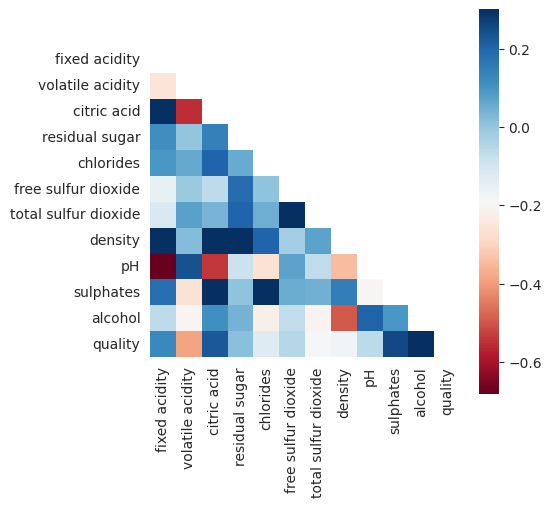

In [8]:
#del wine['quality']
corr = wine.corr()    # data frame correlation function

mask = np.zeros_like(corr)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(5, 5))

    ax = sns.heatmap(corr, mask=mask, cmap='RdBu', vmax=.3, square=True)

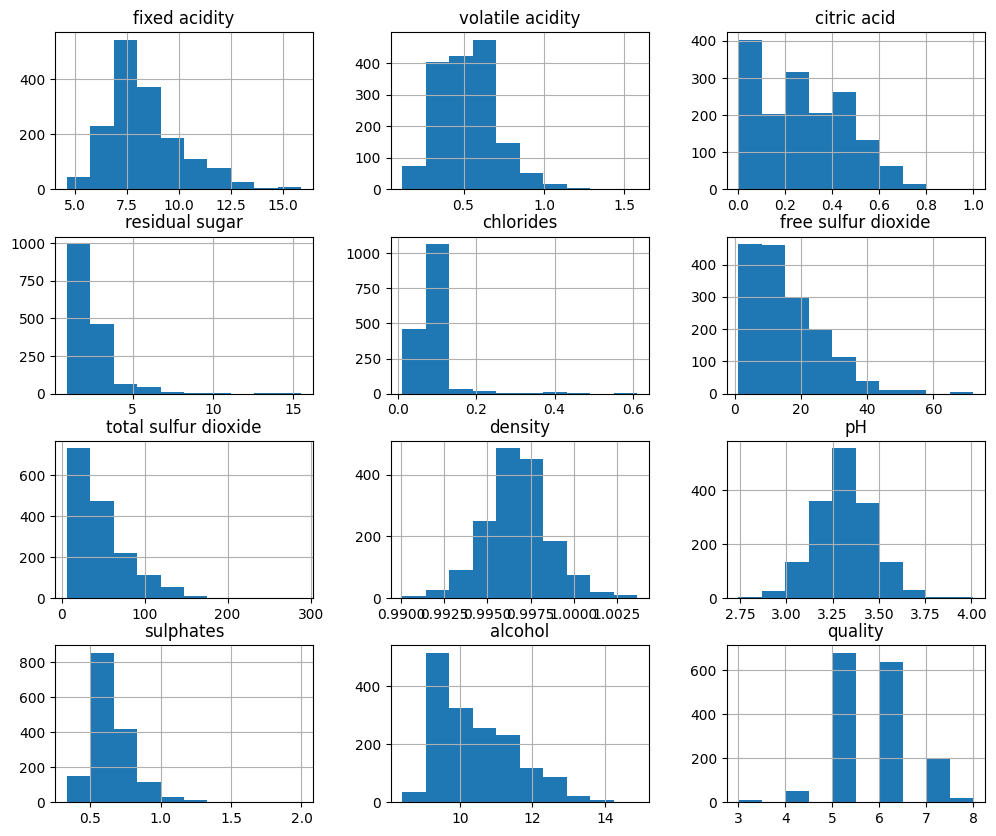

In [9]:
wine.hist(figsize=(12, 10))
plt.show()

<Axes: xlabel='quality', ylabel='volatile acidity'>

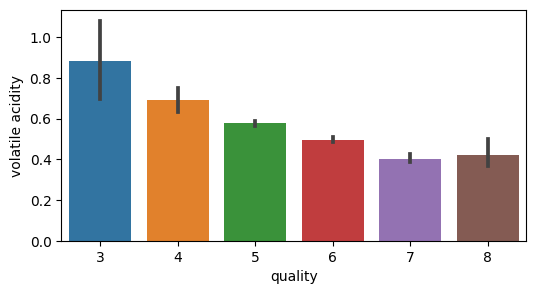

In [10]:
# Relação quality x volatile acidity
fig = plt.figure(figsize = (6,3))
sns.barplot(x = 'quality', y = 'volatile acidity', data = wine)

<Axes: xlabel='quality', ylabel='citric acid'>

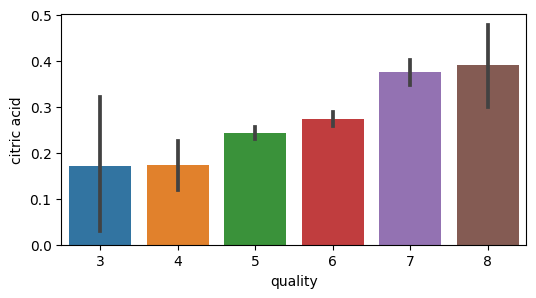

In [11]:
# Relação quality x citric acid
fig = plt.figure(figsize = (6,3))
sns.barplot(x = 'quality', y = 'citric acid', data = wine)

<Axes: xlabel='quality', ylabel='chlorides'>

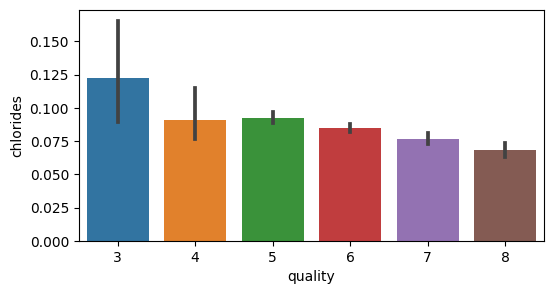

In [12]:
# Relação quality x chlorides
fig = plt.figure(figsize = (6,3))
sns.barplot(x = 'quality', y = 'chlorides', data = wine)

<Axes: xlabel='quality', ylabel='free sulfur dioxide'>

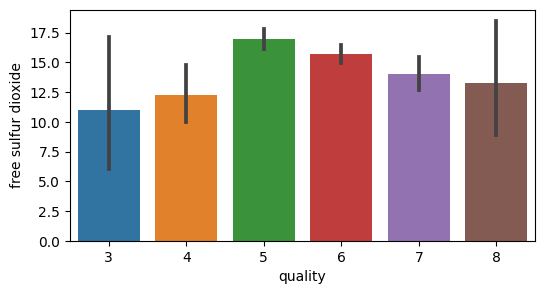

In [13]:
# Relação quality x free sulfur dioxide
fig = plt.figure(figsize = (6,3))
sns.barplot(x = 'quality', y = 'free sulfur dioxide', data = wine)

<Axes: xlabel='quality', ylabel='total sulfur dioxide'>

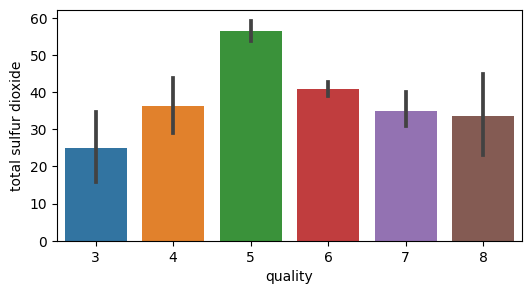

In [14]:
# Relação quality x total sulfur dioxide
fig = plt.figure(figsize = (6,3))
sns.barplot(x = 'quality', y = 'total sulfur dioxide', data = wine)

<Axes: xlabel='quality', ylabel='alcohol'>

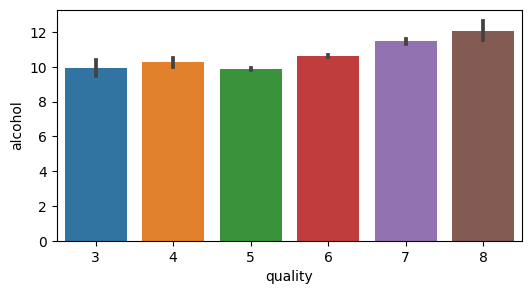

In [15]:
# Relação quality x alcohol
fig = plt.figure(figsize = (6,3))
sns.barplot(x = 'quality', y = 'alcohol', data = wine)

<Axes: xlabel='quality', ylabel='sulphates'>

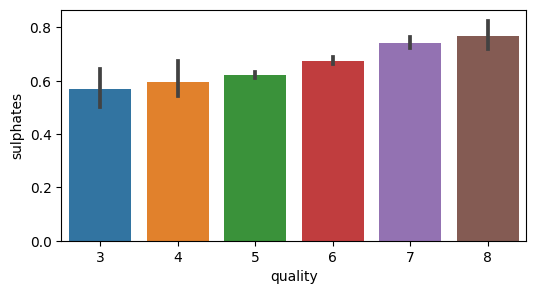

In [16]:
# Relação quality x sulphates
fig = plt.figure(figsize = (6,3))
sns.barplot(x = 'quality', y = 'sulphates', data = wine)

<Axes: xlabel='quality', ylabel='pH'>

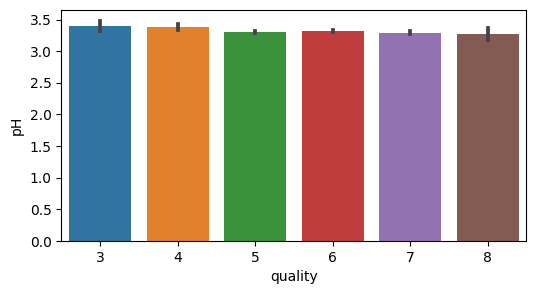

In [17]:
# Relação quality x sulphates
fig = plt.figure(figsize = (6,3))
sns.barplot(x = 'quality', y = 'pH', data = wine)

## Pré-processamento

Convertendo a variável de qualidade de numérica para nominal para fins de classificação. A abordagem envolve transformar a escala numérica em uma classificação binária, distinguindo entre vinhos "ruins" e "bons".

Originalmente, a variável de qualidade variava de 2 a 8, mas para simplificar a classificação, definimos dois intervalos:

* **Ruins:** vinhos com qualidade entre 2 e 6.5
* **Bons:** vinhos com qualidade acima de 6.5


In [18]:
bins = (2, 6.5, 8)
group_names = ['ruim', 'bom']
wine['quality'] = pd.cut(wine['quality'], bins = bins, labels = group_names)

In [19]:
# Criando um codificador para converter a qualidade para numeral(0 e 1)
label_quality = LabelEncoder()

In [20]:
# Vinhos bons se tornarão 0 enquanto os ruins serão identificados por 1
wine['quality'] = label_quality.fit_transform(wine['quality'])

In [21]:
num_true = len(wine.loc[wine['quality'] == 0])
num_false = len(wine.loc[wine['quality'] == 1])
print("Vinhos bons:  {0} ({1:2.2f}%)".format(num_true, (num_true/ (num_true + num_false)) * 100))
print("vinhos ruins: {0} ({1:2.2f}%)".format(num_false, (num_false/ (num_true + num_false)) * 100))

Vinhos bons:  217 (13.57%)
vinhos ruins: 1382 (86.43%)


In [22]:
# Divisão dos vetores de caracteristicas e rotulos
X = wine.drop('quality', axis = 1)
y = wine['quality']

In [23]:
# Divisão do dataset: 75% para treino, 25% para teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [24]:
print("Quantidade de amostras no treino: {0:0.2f}% ".format((len(X_train)/len(wine.index)) * 100))
print(X_train.shape)
print(y_train.shape)

Quantidade de amostras no treino: 74.98% 
(1199, 11)
(1199,)


In [25]:
print("Quantidade de amostras no teste: {0:0.2f}%".format((len(X_test)/len(wine.index)) * 100))
print(X_test.shape)
print(y_test.shape)

Quantidade de amostras no teste: 25.02%
(400, 11)
(400,)


## Classificação

* Naive Bayes Gaussian



In [26]:
nbc =  GaussianNB()

In [27]:
#Treino
nbc.fit(X_train, y_train)

GaussianNB()

In [28]:
# Teste
pred_nbc = nbc.predict(X_test)

In [29]:
acuracia_nbc = accuracy_score(y_test, pred_nbc)
print("Acurácia:", acuracia_nbc)

Acurácia: 0.8525


In [30]:
print(classification_report(y_test, pred_nbc))

              precision    recall  f1-score   support

           0       0.47      0.75      0.58        53
           1       0.96      0.87      0.91       347

    accuracy                           0.85       400
   macro avg       0.71      0.81      0.74       400
weighted avg       0.89      0.85      0.87       400



In [31]:
print(confusion_matrix(y_test, pred_nbc))

[[ 40  13]
 [ 46 301]]


In [32]:
# Aplicação da validação cruzada no classificador Naive Bayes
nbc_eval = cross_val_score(estimator = nbc, X = X_train, y = y_train, cv = 10)
print("Media da validação cruzada do classificador Naive Bayes", nbc_eval.mean())

Media da validação cruzada do classificador Naive Bayes 0.8373459383753501


* MLP

In [33]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Normalizando os dados (isso é especialmente importante para redes neurais)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Criando e treinando o classificador MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)

# Realizando previsões no conjunto de teste
pred_mlp = mlp.predict(X_test_scaled)

# Avaliando o desempenho do classificador MLP
print(classification_report(y_test, pred_mlp))


              precision    recall  f1-score   support

           0       0.67      0.53      0.59        53
           1       0.93      0.96      0.94       347

    accuracy                           0.90       400
   macro avg       0.80      0.74      0.77       400
weighted avg       0.90      0.90      0.90       400



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [34]:
acuracia_mlp = accuracy_score(y_test, pred_mlp)
print("Acurácia:", acuracia_mlp)

Acurácia: 0.9025


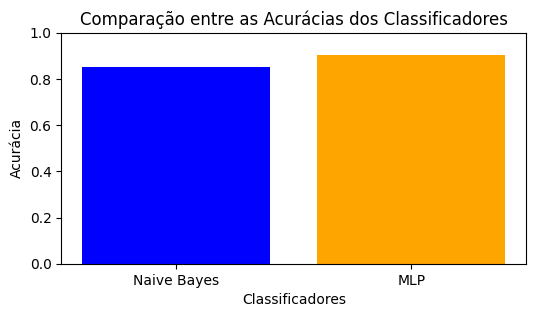

In [35]:
# Acurácias dos classificadores
accuracies = [acuracia_nbc, acuracia_mlp]
classifiers = ['Naive Bayes', 'MLP']

# Criar o gráfico de barras
plt.figure(figsize=(6, 3))
plt.bar(classifiers, accuracies, color=['blue', 'orange', 'green'])
plt.title('Comparação entre as Acurácias dos Classificadores')
plt.xlabel('Classificadores')
plt.ylabel('Acurácia')
plt.ylim(0, 1)  # Define o limite do eixo y de 0 a 1 (intervalo de acurácia)
plt.show()

In [36]:
conf_matrix_nb = confusion_matrix(y_test, pred_nbc)
print("Matriz de Confusão (Naive Bayes):\n", conf_matrix_nb)

Matriz de Confusão (Naive Bayes):
 [[ 40  13]
 [ 46 301]]


In [37]:
conf_matrix_mlp = confusion_matrix(y_test, pred_mlp)
print("Matriz de Confusão (MLP):\n", conf_matrix_mlp)

Matriz de Confusão (MLP):
 [[ 28  25]
 [ 14 333]]


['Class 0', 'Class 1']


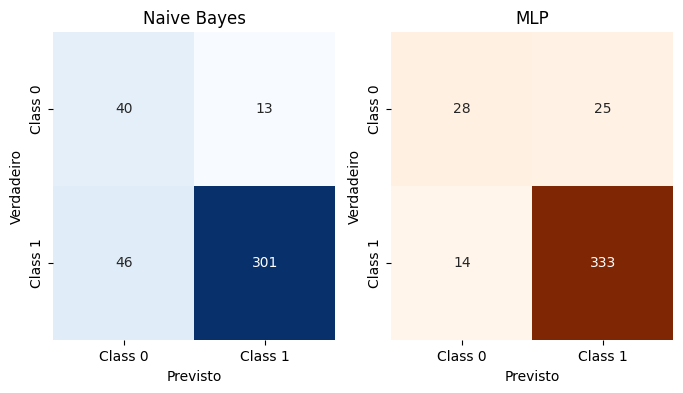

In [38]:
# Nomes das classes
class_names = [f'Class {i}' for i in range(len(set(y_test)))]

print(class_names)

# Configurar subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Matriz de Confusão - Naive Bayes
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0], xticklabels=class_names, yticklabels=class_names)
axs[0].set_title('Naive Bayes')
axs[0].set_xlabel('Previsto')
axs[0].set_ylabel('Verdadeiro')

# Matriz de Confusão - MLP
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Oranges', cbar=False, ax=axs[1], xticklabels=class_names, yticklabels=class_names)
axs[1].set_title('MLP')
axs[1].set_xlabel('Previsto')
axs[1].set_ylabel('Verdadeiro')


plt.show()

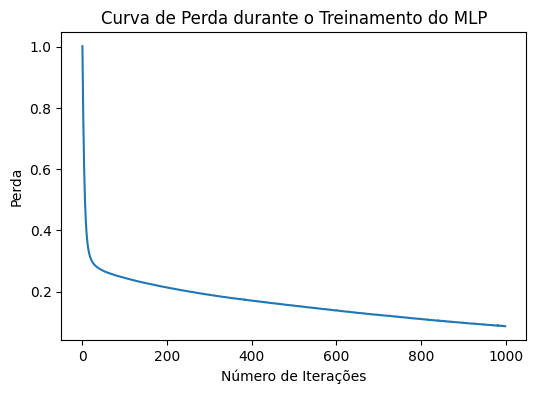

In [40]:
plt.figure(figsize=(6, 4))
plt.plot(mlp.loss_curve_)
plt.title("Curva de Perda durante o Treinamento do MLP")
plt.xlabel("Número de Iterações")
plt.ylabel("Perda")
plt.show()